In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error

In [2]:
years = [2009,2010,2011,2012,2013,2014,2015]
path ='/public/npatil4/dataMining/data/daily/combined_wide/'
files = [path+'combined_wide_'+str(year)+'.csv' for year in years]

In [3]:
data = [pd.read_csv(file_name,sep='|') for file_name in files]

In [4]:
[df.shape for df in data]

[(148428, 18),
 (160416, 18),
 (157975, 18),
 (168291, 18),
 (184197, 18),
 (196085, 18),
 (206363, 18)]

In [5]:
data= pd.concat(data, ignore_index=True)

In [6]:
data['DateLocal'] = pd.to_datetime(data.DateLocal)
data['year'] = data.DateLocal.dt.year
data['weekNo'] = data.DateLocal.dt.week
data['Weekday'] = data.DateLocal.dt.weekday

In [7]:
data.head(2).transpose()

,0,1
DateLocal,2009-01-01 00:00:00,2009-01-01 00:00:00
CityName,Aberdeen,Adjuntas
CountyName,Brown,Adjuntas
StateName,South Dakota,Puerto Rico
Latitude,45.4625,18.17538
Longitude,-98.48611,-66.72599
Barometricpressure,NaN,NaN
Carbonmonoxide,NaN,NaN
DewPoint,NaN,NaN
NitrogenDioxide,NaN,NaN


In [8]:
data_missing = data.isnull()

In [9]:
data_missing_count = data_missing.ix[:,6:-4].apply(sum,1).groupby([data.CountyName,
                                                                   data.CityName]
                                                                 ).mean()

data_missing_count = pd.DataFrame(data_missing_count[data_missing_count>=8]).reset_index()

In [10]:
data_pol = data.ix[:,:-4].groupby([
       'DateLocal',
       'CityName', 'CountyName',
       'Latitude','Longitude'],
        as_index=False).mean()


In [11]:
data_model = pd.read_csv('../data/daily/combined_wide/combined_wide_all_filled_si.txt',
                         sep='|')

In [12]:
data_model['CityName'] = data_pol.CityName
data_model['CityName'] = data_model.CityName.astype('category')
data_model['date'] = data_pol.DateLocal
data_model['weekNo'] = data_model.date.dt.weekofyear
data_model['weekNo'] = data_model.weekNo.astype('category')
data_model['yearNo'] = data_model.date.dt.year
data_model['yearNo'] = data_model.yearNo.astype('category')
data_model['monthNo'] = data_model.date.dt.month
data_model['monthNo'] = data_model.monthNo.astype('category')
data_model['pm_mean_month'] = data_model.PM.groupby([data_model.CityName,
                                                     data_model.yearNo,
                                                     data_model.monthNo]).transform('mean')
data_model['pm_mean_weekNo'] = data_model.PM.groupby([data_model.CityName,
                                                     data_model.yearNo,
                                                     data_model.weekNo]).transform('mean')
data_model['PM'] = pd.Series([0]).append(data_model.PM[:-1]).reset_index(drop=True)

In [13]:
RandomState = 42
train = data_model.sample(frac=0.7,random_state=RandomState)
test = data_model[~(data_model.index.isin(train.index))]

In [14]:
columns = ['Carbonmonoxide',
           'DewPoint',
           'NitrogenDioxide',
           'OutdoorTemperature',
           'Ozone',
           'RelativeHumidity',
           'Sulfurdioxide',
           'weekNo',
           'monthNo',
           'pm_mean_month',
           'pm_mean_weekNo']

In [15]:
X = train[columns]
y = train.PM

#### Random Forest : number of trees

In [16]:
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor


ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestRegressor(warm_start=True,
                              oob_score=True,
                              max_features="sqrt",
                              random_state=RandomState)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestRegressor(warm_start=True,
                              max_features='log2',
                              oob_score=True,
                              random_state=RandomState)),
    ("RandomForestClassifier, max_features=None",
        RandomForestRegressor(warm_start=True,
                              max_features=None,
                              oob_score=True,
                              random_state=RandomState))
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

In [ ]:
### Range of `n_estimators` values to explore.
min_estimators = 5
max_estimators = 1000

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1,2):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)
### Record the OOB error for each `n_estimators=i` setting.
        oob_error = mean_squared_error(clf.oob_prediction_,y)
        error_rate[label].append((i, oob_error))

In [ ]:
### Generate the "OOB error rate" vs. "n_estimators" plot.
plot_comparison = sns.plt.figure(figsize=(15,5))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right",)
plot_comparison.savefig(path_plot+'comparison_si_month.png',dpi=250)

#### Random Forest

In [18]:
rf = RandomForestRegressor(oob_score=True,
                           warm_start=True,
                           max_features='log2',
                           random_state=RandomState,
                           n_estimators=50)
rf.fit(X=X,y=y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=True)

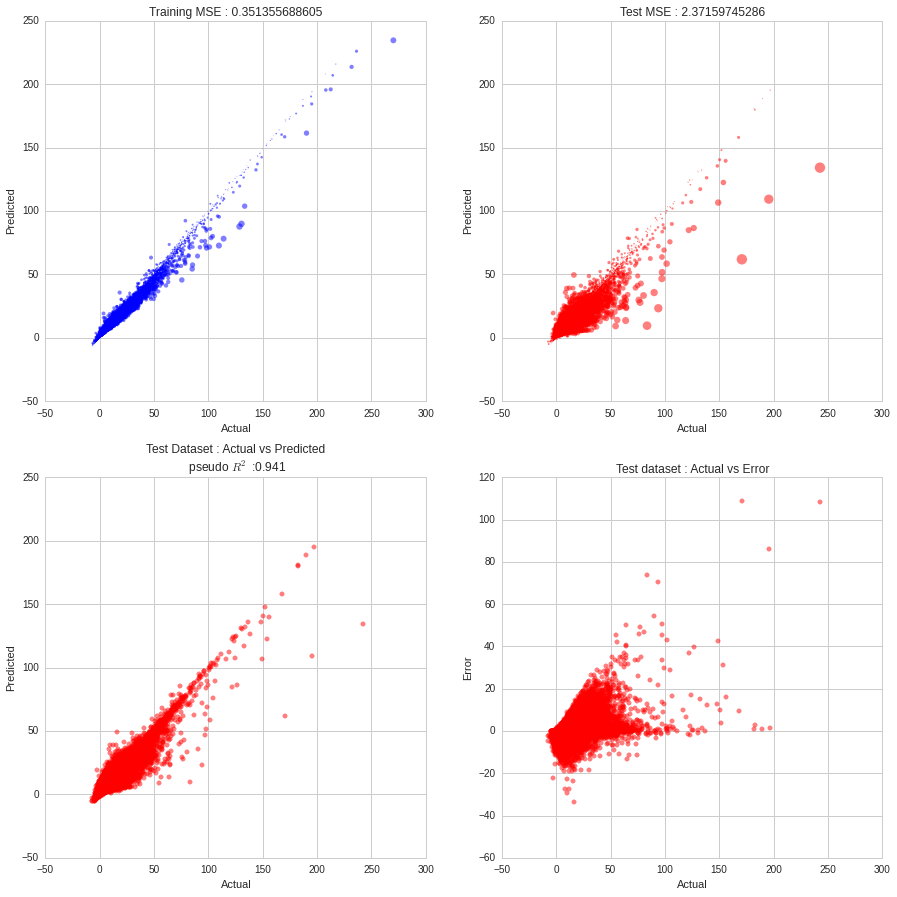

In [22]:
path_plot = '../plots/Matrix_completion_results_'

x_train = train.PM
y_train = rf.predict(X)
error_train = x_train-y_train

x_test = test.PM
y_test = rf.predict(test[columns])
error_test = x_test-y_test

q = pd.DataFrame({  'x':x_test,
                    'y':y_test,
                    'error_test':error_test
                }).reset_index(drop=True)
q = q.sort(['x'],inplace=False)
rf_rSquared = round(explained_variance_score(x_test,y_test),3)

mice_plot = sns.plt.figure(figsize=(15,15))
sns.set_style('whitegrid')


mice_plot.add_subplot(221)
sns.plt.scatter(x_train,
                y_train,
                linewidths=0.0,
                s = abs(error_train),
                c='blue',
                alpha=0.5)
sns.plt.title('Training MSE : '+str(mean_squared_error(x_train,y_train)))
sns.plt.xlabel('Actual')
sns.plt.ylabel('Predicted')

mice_plot.add_subplot(222)
sns.plt.scatter(x_test,
                y_test,
                linewidths=0.0,
                s = abs(error_test),
                c='red',
                alpha=0.5)
sns.plt.title('Test MSE : '+str(mean_squared_error(x_test,y_test)))
sns.plt.xlabel('Actual')
sns.plt.ylabel('Predicted')

mice_plot.add_subplot(223)
sns.plt.scatter(x_test,
                y_test,
                alpha=0.5,
                color='r')
sns.plt.title('Test Dataset : Actual vs Predicted \n pseudo $R^2$ :'+str(rf_rSquared))
sns.plt.xlabel('Actual')
sns.plt.ylabel('Predicted')

mice_plot.add_subplot(224)
sns.plt.scatter(x_test,
                error_test,
                alpha=0.5,
                color='r')
sns.plt.title('Test dataset : Actual vs Error')
sns.plt.xlabel('Actual')
sns.plt.ylabel('Error')


plt.savefig(path_plot+'si_month_week_aggregates_rf.png',dpi = 750)

In [23]:
model_vars = pd.DataFrame(
             {'variable':columns,
              'importance':rf.feature_importances_})

model_vars.sort('importance',ascending=False,inplace=True)
model_vars.head()

,importance,variable
6,0.262466,Sulfurdioxide
10,0.190127,pm_mean_weekNo
0,0.112648,Carbonmonoxide
2,0.097601,NitrogenDioxide
1,0.073199,DewPoint


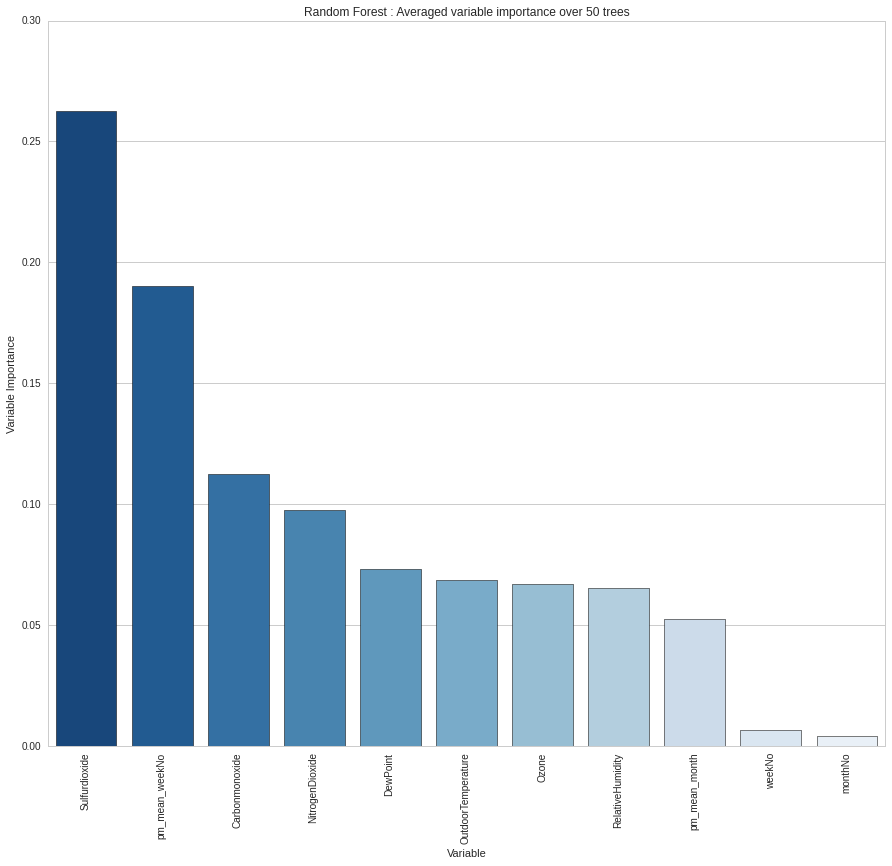

In [24]:
sns.plt.figure(figsize=(15,13))


sns.barplot(y='importance',
            x='variable',
            data=model_vars,
            palette=sns.color_palette("Blues_r",
                                      n_colors=len(model_vars.variable)),
            linewidth=0.5)
sns.plt.xticks(rotation=90)
sns.plt.xlabel('Variable')
sns.plt.ylabel('Variable Importance')
sns.plt.title('Random Forest : Averaged variable importance over 50 trees')

sns.plt.savefig('../plots/VariableImportance_rf.png',dpi=500)